# Introdução à Computação Visual
## TP1 - Compressor
* Gabriel Person
* Lucas Mundim

Implementação de um compressor de imagens usando `python 3.6` e `OpenCV 3.4.3` para a disciplina *Introdução à Computação Visual* - UFMG 2018/2

---
A ideia geral do compressor a ser implementado é a mesma do algoritmo de compressão JPEG, seguindo os passos:
1. Ler a imagem
2. Compressão
3. Cálculo de taxa de compressão e de SNRF
4. Gravar imagem comprimida em disco
5. Descompressão da imagem

### Inicialização

In [1]:
import io
import os
import numpy as np
import cv2 as cv
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

print('Python: ', os.sys.version)
print('OpenCV: ', cv.__version__)

Python:  3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
OpenCV:  3.4.3


### Métodos auxiliares
* Cálculo da DCT
* Cálculo da IDCT (DCT Inversa)
* Cálculo da RMSE
* Cálculo da PSNR (Peak signal-to-noise ratio)

In [2]:
def img_dct(img):
    return fftpack.dct(fftpack.dct(img.T,norm='ortho').T, norm='ortho')

def img_idct(coef):
    return fftpack.idct(fftpack.idct(coef.T, norm='ortho').T, norm='ortho')

def rmse(pred, target):
    return np.sqrt(((pred-target) ** 2).mean())

def psnr(pred, target):
    rmsev = rmse(pred, target)
    return 20 * np.log10(255/rmsev)

### Valores auxiliares
* Tamanho do bloco a ser utilizado

Com o tamanho de bloco escolhido (8), imagens com dimensões que não sejam múltiplas de 8 não são possíveis de serem comprimidas.

* Matriz de quantização

Foi escolhida uma matriz de quantização comumente utilizada em compressões JPEG

In [3]:
tam_bloco = 8
#matriz de quantização
quant = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 7],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]])
quant = quant.astype(float)

### Leitura da imagem

In [4]:
image_name = 'HowDidWeGetSoDark.jpg'

img_in = cv.imread(image_name,0)
img_in = img_in.astype(float)
img_in = img_in-128

lin, col = np.shape(img_in)

num_parts = int((lin/tam_bloco)*(lin/tam_bloco))
IDCT = img_cmp = np.zeros((lin,col),dtype=float)
DCT = img_cmp = np.zeros((lin,col),dtype=float)

### DCT e IDCT

Imagem original


True

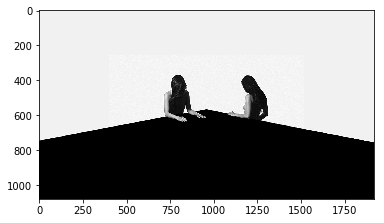

In [5]:
#Sub divisão em blocos de 8x8
tiles = [img_in[x:x+8,y:y+8] for x in range(0,img_in.shape[0],8) for y in range(0,img_in.shape[1],8)]

for i in range(0,lin,tam_bloco):
    for j in range(0,col,tam_bloco):
        dct = img_dct(img_in[i:i+tam_bloco, j:j+tam_bloco])
        idct = img_idct(dct)
        IDCT[i:i+tam_bloco, j:j+tam_bloco] = idct
        DCT[i:i+tam_bloco, j:j+tam_bloco] = dct

img_in = img_in+128
IDCT = IDCT+128

print('Imagem original')
plt.imshow(img_in,cmap='gray')

cv.imwrite("dct.png",DCT)
cv.imwrite("idct.png",IDCT)


#sub 128 
#for i in range(num_parts): tiles[i] = tiles[i]-128
#for i in range(num_parts): tiles[i] = (np.float32(tiles[i])/255.0)
#calculo DCT
#for i in range(num_parts): tiles[i] = cv.dct(tiles[i])
#quantizacao
#for i in range(num_parts): tiles[i] = tiles[i]/quant
#for i in range(num_parts): tiles[i] = (np.float32(tiles[i])*255.0)
#for i in range(num_parts):
#    for j in range(8):
#        for k in range(8):
#            tiles[i][j][k] = round(tiles[i][j][k],0)
#
#print(img_in.size)
#plt.imshow(img1,cmap='gray')

DCT


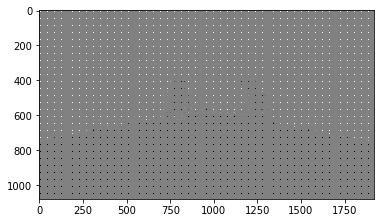

In [6]:
print('DCT')
plt.imshow(DCT,cmap='gray')

IDCT


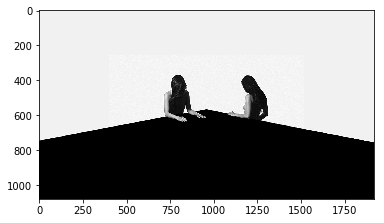

In [7]:
print('IDCT')
plt.imshow(IDCT,cmap='gray')

### Compressão

RMSE: 1.399
PSNR: 45.216


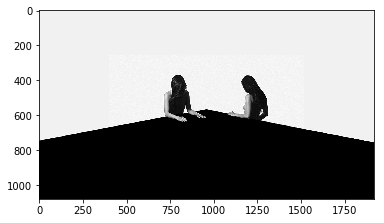

In [8]:
#Compressão usando matriz de quantização

img_in = img_in-128

useDC = True

for i in range(0,lin,tam_bloco):
    for j in range(0,col,tam_bloco):
        dct = img_dct(img_in[i:i+tam_bloco, j:j+tam_bloco])
        odct = dct
        DC = dct[0,0]
        
        dct = np.divide(dct, quant)
        dct = dct.round()
        coddct = dct
        
        dct = np.multiply(dct, quant)
        if(useDC == True):
            dct[0,0] = DC
        IDCT[i:i+tam_bloco, j:j+tam_bloco] = img_idct(dct)
        
IDCT = IDCT+128
img_in = img_in+128

print ("RMSE: %5.3f" % rmse(img_in, IDCT))
print ("PSNR: %5.3f" % psnr(img_in, IDCT))

plt.imshow(img_in,cmap='gray')

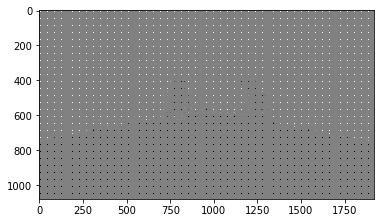

In [9]:
plt.imshow(DCT,cmap='gray')

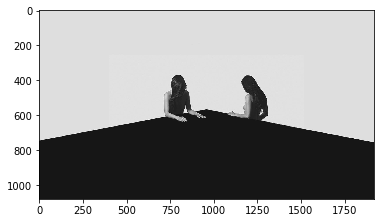

In [12]:
plt.imshow(IDCT,cmap='gray')

2073600


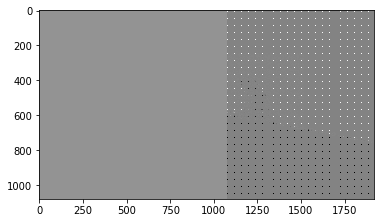

In [13]:
#Reagrupamento dos blocos 8x8 na imagem comprimida
lin, col = 1, 1
size_y = int(len(img_in)/8)
size_x = int(len(img_in[0])/8)

for i in range(num_parts):
    tiles[0]=tiles[i]
    for j in range(size_y):
        for k in range(size_x):
            img_cmp[8*j:8*(j+1),8*k:8*(k+1)] = tiles[0]
            if k==size_y-1:
                j=0
plt.imshow(img_cmp,cmap='gray')
cv.imwrite("HowDidWeGetSoDark2.jpg",img_cmp)
print(img_cmp.size)